In [ ]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


### Loading in data

In [ ]:
image_dir = '../data'
image_size = (32, 32)
batch_size = 64

def custom_preprocess(x):
    x = (x - 127.5) / 127.5
    return x

image_generator = ImageDataGenerator(
    preprocessing_function=custom_preprocess, # rescale [0.0 - 255.0] to [-1.0 to 1.0] range
    validation_split=0.2,
    horizontal_flip=True,
)

train_data = image_generator.flow_from_directory(
    image_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None,  # No labels needed for GAN training
    subset='training'
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data,
    output_signature=tf.TensorSpec(shape=(None, image_size[0], image_size[1], 3), dtype=tf.float32),
)

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
class Generator(Layer):
    def __init__(self, n_hidden, n_c):
        super(Generator, self).__init__()
        self.n_hidden = n_hidden
        self.n_c = n_c  # number of chanells, I want to generate RGB so it's  set to 3

        self.dense1 = tf.keras.layers.Dense(256 * 4 * 4)
        self.reshape = tf.keras.layers.Reshape((4, 4, 256))
        self.upsample1 = tf.keras.layers.UpSampling2D(size=(2, 2))
        self.conv1 = tf.keras.layers.Conv2DTranspose(128, kernel_size=5, padding='same')
        self.upsample2 = tf.keras.layers.UpSampling2D(size=(2, 2))
        self.conv2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=5, padding='same')
        self.upsample3 = tf.keras.layers.UpSampling2D(size=(2, 2))
        self.conv3 = tf.keras.layers.Conv2DTranspose(32, kernel_size=5, padding='same')
        self.conv4 = tf.keras.layers.Conv2DTranspose(n_c, kernel_size=1, padding='same')

    def call(self, Z):
        h = tf.nn.leaky_relu(self.dense1(Z), 0.2)
        h = self.reshape(h)
        h = self.upsample1(h)
        h = tf.nn.leaky_relu(self.conv1(h), 0.2)
        h = self.upsample2(h)
        h = tf.nn.leaky_relu(self.conv2(h), 0.2)
        h = self.upsample3(h)
        h = tf.nn.leaky_relu(self.conv3(h), 0.2)
        x = self.conv4(h)
        return x
        

In [ ]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
        self.conv3 = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(1)

    def call(self, X):
        h = tf.nn.leaky_relu(self.conv1(X))
        h = tf.nn.leaky_relu(self.conv2(h))
        h = tf.nn.leaky_relu(self.conv3(h))
        h = self.flatten(h)
        logits  = self.dense1(h)
        return logits 

In [ ]:
def cross_entropy_loss(logits, labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))

def get_noise(n_batch, noise_var):
    return np.random.randn(n_batch, noise_var).astype(np.float32)

def visualize_images(images, n_rows, n_cols, title=None):
    _, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]
            ax.imshow(images[i * n_cols + j])
            ax.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    if title:
        plt.suptitle(title, fontsize=16)
    plt.show()

def plot_learning_curve(g_loss_history, d_g_z_loss_history, d_x_loss_history, d_loss_history):
    plt.figure(figsize=(12, 6))
    plt.plot(g_loss_history, label='Generator Loss', alpha=0.7)
    plt.plot(d_g_z_loss_history, label='Discriminator (Generated) Loss', alpha=0.7)
    plt.plot(d_x_loss_history, label='Discriminator (Real) Loss', alpha=0.7)
    plt.plot(d_loss_history, label='Discriminator Total Loss', alpha=0.7)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Learning Curves')
    plt.grid(True)
    plt.show()

### Initialize parameters for GAN model

In [ ]:
n_hidden, n_w, n_c = [32, 32, 3]
noise_var = 128
n_batch = 100
lr = 2.5e-4
n_updates_total = 55000
noise_vector = get_noise(n_batch, noise_var)

#### Generator

In [ ]:
X = tf.keras.layers.Input(shape=(n_hidden, n_w, n_c), dtype=tf.float32)
Z = tf.keras.layers.Input(shape=(noise_var,), dtype=tf.float32)

generator = Generator(n_hidden=n_hidden, n_c=n_c)
discriminator = Discriminator()

g_z = generator(Z)
d_g_z = discriminator(g_z)
d_x = discriminator(X)

g_loss = cross_entropy_loss(logits=d_g_z, labels=tf.ones(tf.shape(d_g_z)))
d_g_z_loss = cross_entropy_loss(logits=d_g_z, labels=tf.zeros(tf.shape(d_g_z)))
d_x_loss = cross_entropy_loss(logits=d_x, labels=tf.ones(tf.shape(d_x)))
d_loss = (d_g_z_loss + d_x_loss) / 2

g_vars = generator.trainable_variables
d_vars = discriminator.trainable_variables

g_optimizer = tf.optimizers.Adam(learning_rate=lr, beta_1=0.5)
d_optimizer = tf.optimizers.Adam(learning_rate=lr, beta_1=0.5)

g_loss_history = []
d_g_z_loss_history = []
d_x_loss_history = []
d_loss_history = []

for n_updates in tqdm(range(n_updates_total), ncols=80, leave=False):
    xs = train_data.next()
    noise_samples = get_noise(n_batch, noise_var)
    
    with tf.GradientTape() as tape:
        d_g_z = discriminator(generator(noise_samples))
        d_x = discriminator(xs)
        
        d_g_z_loss = cross_entropy_loss(logits=d_g_z, labels=tf.zeros_like(d_g_z))
        d_x_loss = cross_entropy_loss(logits=d_x, labels=tf.ones_like(d_x))
        d_loss = (d_g_z_loss + d_x_loss) / 2
    
    d_gradients = tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
    
    # Training steps for the generator
    with tf.GradientTape() as tape:
        g_z = generator(noise_samples)
        d_g_z = discriminator(g_z)
        g_loss = cross_entropy_loss(logits=d_g_z, labels=tf.ones_like(d_g_z))
    
    g_gradients = tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

    if n_updates % 100 == 0:
        g_loss_history.append(g_loss)
        d_g_z_loss_history.append(d_g_z_loss)
        d_x_loss_history.append(d_x_loss)
        d_loss_history.append(d_loss)
    
    if n_updates % 1000 == 0:
        generated_images = generator(noise_vector)
        generated_images = generated_images / 2 + 0.5 # Rescale to [0, 1] range
        n_rows = 10
        n_cols = 10
        visualize_images(generated_images, n_rows, n_cols, title=f"Generated images after {n_updates} iterations")
        plot_learning_curve(g_loss_history, d_g_z_loss_history, d_x_loss_history, d_loss_history)
    
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

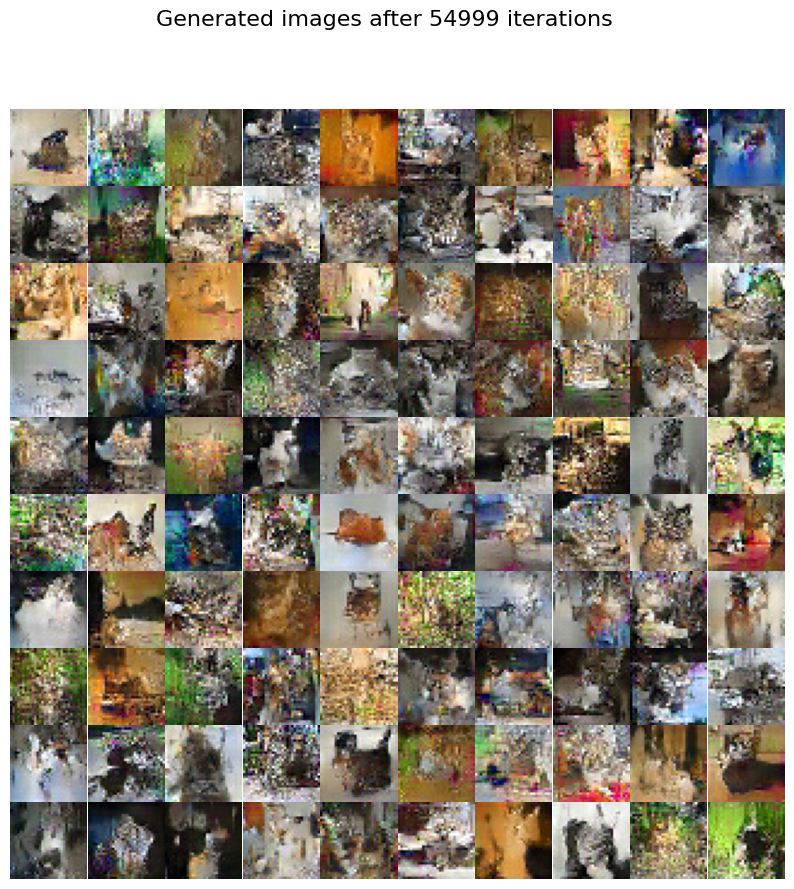

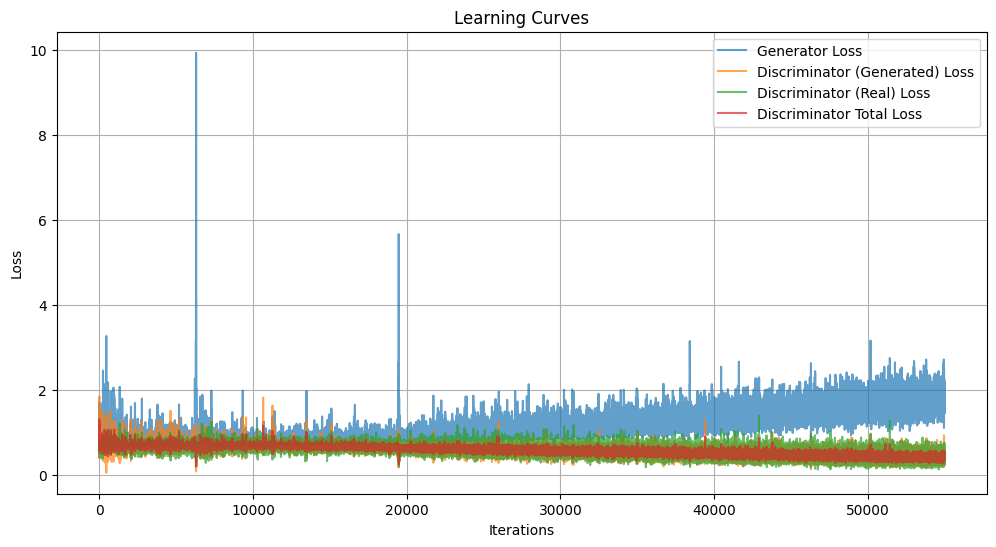

In [8]:
generated_images = generator(noise_vector)
generated_images = generated_images / 2 + 0.5 # Rescale to [0, 1] range
n_rows = 10
n_cols = 10
visualize_images(generated_images, n_rows, n_cols, title=f"Generated images after {n_updates} iterations")
plot_learning_curve(g_loss_history, d_g_z_loss_history, d_x_loss_history, d_loss_history)